In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
cd ..

In [2]:
timber_df = pd.read_csv('Data/Cleaned Timber Data.csv')

In [3]:
#create the training and test set - I am choosing to use 80% of the data as training data because I don't think
#the sample size is large enough to use more than 80% for training
X_train, X_test = train_test_split(timber_df, test_size = 0.2,random_state=9172020)

In [4]:
#after many different combinations of variables, I found the combination below to work the best
X = X_train[['Ccf Mbf','Acres Current Standardized','Acre Volume']]
y = X_train['Value Sold Standardized']
X = sm.add_constant(X)
mod_initial = sm.OLS(y, X, hasconst= True)
res_initial = mod_initial.fit()
print(res_initial.summary())

                               OLS Regression Results                              
Dep. Variable:     Value Sold Standardized   R-squared:                       0.707
Model:                                 OLS   Adj. R-squared:                  0.706
Method:                      Least Squares   F-statistic:                     714.7
Date:                     Tue, 22 Sep 2020   Prob (F-statistic):          3.20e-236
Time:                             14:47:53   Log-Likelihood:                -724.87
No. Observations:                      892   AIC:                             1458.
Df Residuals:                          888   BIC:                             1477.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [5]:
#The R-squared value isn't great (70.7%), but the predictors show significant p-values and other combinations of variables didn't
#yield any higher R-squared and the coefficient values seem to offer a logical interpretation of the predictors
#relationship to the value sold

Text(0, 0.5, 'Residuals')

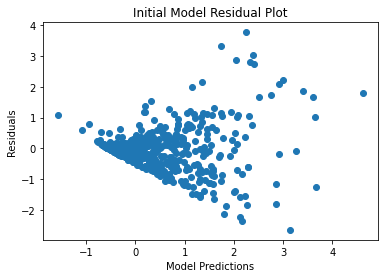

In [6]:
#now to show the residual plot
plt.scatter(res_initial.predict(),res_initial.resid)
plt.title("Initial Model Residual Plot")
plt.xlabel("Model Predictions")
plt.ylabel("Residuals")
#plt.savefig('initial_model_residuals.png')

In [7]:
#These residuals are showing a very strong fanning pattern, which suggest uneven variance
#I will try to predict the square root of the Value Sold (target) in hope of evening out the variance

In [8]:
#I am running a model with the same predictors, but am using the square root of the target variable is the dependent variable this time
X = X_train[['Ccf Mbf','Acres Current Standardized','Acre Volume']]
y = X_train['Value Sold sqrt standardized']
X = sm.add_constant(X)
mod_secondary = sm.OLS(y, X, hasconst= True)
res_secondary = mod_secondary.fit()
print(res_secondary.summary())

                                 OLS Regression Results                                 
Dep. Variable:     Value Sold sqrt standardized   R-squared:                       0.816
Model:                                      OLS   Adj. R-squared:                  0.815
Method:                           Least Squares   F-statistic:                     1313.
Date:                          Tue, 22 Sep 2020   Prob (F-statistic):               0.00
Time:                                  14:47:56   Log-Likelihood:                -518.79
No. Observations:                           892   AIC:                             1046.
Df Residuals:                               888   BIC:                             1065.
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

Text(0, 0.5, 'Residuals')

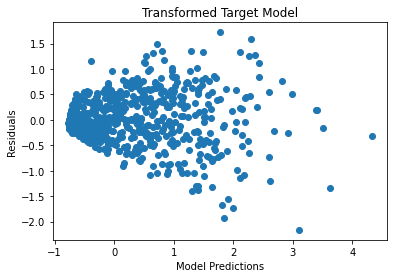

In [9]:
#now to show the residual plot
plt.scatter(res_secondary.predict(),res_secondary.resid)
plt.title("Transformed Target Model")
plt.xlabel("Model Predictions")
plt.ylabel("Residuals")
#plt.savefig('transformed_target_residuals.png')

In [10]:
#The variance of the model has evened out quite a bit! This is good to see. 
#Also, the R-squared jumped up by almost 10% - but this is usually expected when transforming the target variable 
#since it is being scaled down

In [11]:
#The next thing that I would like to look for is any outliers or high-leverage observations. Since there are multiple
#predictors, I am thinking a good way to visually see if the coefficients are being leveraged by observations is by 
#looking at a partial regression plot and an influence plot

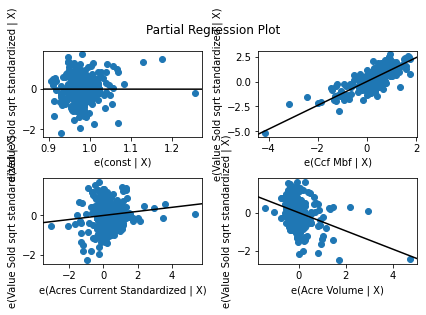

In [12]:
#running a partial regression plot using statsmodels.api
fig = sm.graphics.plot_partregress_grid(res_secondary)
fig.tight_layout(pad=1.0)

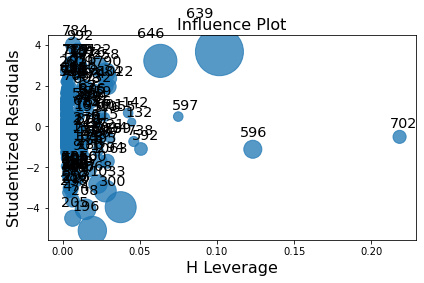

In [13]:
#showing the cooks distances for various residuals to gain inference on high leverage points
fig = sm.graphics.influence_plot(res_secondary, criterion="cooks")
fig.tight_layout(pad=1.0)

In [14]:
#When looking at these plots, the partial regression of "Ccf Mbf" looks fine. The partial regression of 
#"Acres Current Standardized" doesn't look great, but I don't think any of the points are bringing the partial regression
#line away from my implied relationship
#When looking at the partial regression of "Acre Volume" I see some strong leverage though. It is evident that the 
#observations in the lower right corner are drastically changing the slope of the partial regression. The points in the
#middle right may be leveraging the line as well.
#The influential points plot agrees with this observation of some very high leverage points, as is represented in
#the size of the dots on the plot.

In [15]:
#I am going to pull the cooks distance calculations from the results and record the observation indeces that are the highest leverage
influencial_points = res_secondary.get_influence()
distances = influencial_points.summary_frame().filter(regex="cooks_d")
distances = pd.Series(distances['cooks_d'])
#I have compared the values of the cooks distances with the labeled indeces on the influential observation plot
#and have decided the values with an absolute cooks distance value over 0.025 are the most noteworthy in terms of their influence
v = .025
upper_leverage_indeces = distances[distances<=-v].index
lower_leverage_indeces = distances[distances>v].index
indeces_to_drop = pd.concat([pd.Series(upper_leverage_indeces),pd.Series(lower_leverage_indeces)],axis=0)

In [16]:
#In total, there are 16 high leverage observations I plan to remove from the training set in order to test their impact
#on the accuracy of the model.
X_train = X_train.drop(indeces_to_drop)

In [17]:
#now to run the regression model to see what impact it had on the accuracy of the model, as well as the partial regressions
X = X_train[['Ccf Mbf','Acres Current Standardized','Acre Volume']]
y = X_train['Value Sold sqrt standardized']
X = sm.add_constant(X)
mod_final = sm.OLS(y, X, hasconst= True)
res_final = mod_final.fit()
print(res_final.summary())

                                 OLS Regression Results                                 
Dep. Variable:     Value Sold sqrt standardized   R-squared:                       0.841
Model:                                      OLS   Adj. R-squared:                  0.841
Method:                           Least Squares   F-statistic:                     1541.
Date:                          Tue, 22 Sep 2020   Prob (F-statistic):               0.00
Time:                                  14:48:04   Log-Likelihood:                -416.79
No. Observations:                           876   AIC:                             841.6
Df Residuals:                               872   BIC:                             860.7
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

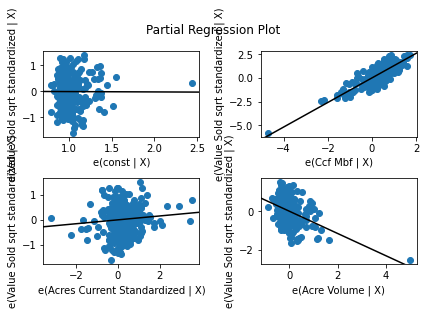

In [18]:
fig = sm.graphics.plot_partregress_grid(res_final)
fig.tight_layout(pad=1.0)

In [19]:
#I see that the R-squared increased by roughly 4% which is very good to see! Also, the partial regression for "Acre Volume"
#looks much much better than before. Also, the partial regression for "Acres Current Standardized" looks better too. And
#lastly, the partial regression for "Ccf Mbf" still looks just good as it did initially. 

In [20]:
#Therefore, I conclude that this model is in good shape and is ready for testing. However, before moving on to the testing
#phase, I want to quickly explore the types of obsevations that ended up being high leverage in order to gain insight
#on what types of observations in future use of the model won't do particularly well. 

Text(0, 0.5, 'Ccf Mbf')

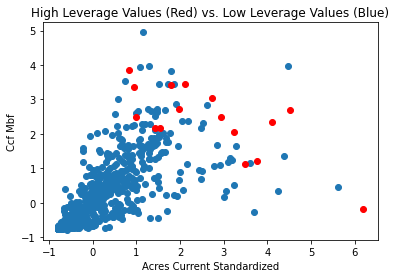

In [21]:
#creating plot that shows the high leverage points (in red) in terms of their relationship to Ccf Mbf and Acres Current Standardized
plt.scatter(X_train['Acres Current Standardized'],X_train['Ccf Mbf'])
plt.scatter(timber_df.loc[indeces_to_drop,'Acres Current Standardized'],timber_df.loc[indeces_to_drop,'Ccf Mbf'],color='red')
plt.title("High Leverage Values (Red) vs. Low Leverage Values (Blue)")
plt.xlabel("Acres Current Standardized")
plt.ylabel("Ccf Mbf")
#plt.savefig('excluded_ovservations.png')

In [22]:
#The scatter plot doesn't show very much of a pattern to which values are high leverage, as there are many
#lower leverage points surrounding them. However, a general rule i can make to avoid making predictions on 
#points similar to the high leverage observations would be to only make predications for observations that 
#fall within the bottom left corner of the scatterplot above because that is a region that holds no red dots.
#The rule I will make will be to only make predictions off contracts with "Ccf Mbf" <=2 and "Acres Current Stadardized" <= 2.
#Below is a calculation of the actual Ccf, Mbf, and Acreage cutoffs associate with these cutoffs in the standardized variables.

In [23]:
#get mean and std for "Ccf", "Mbf", and "Acres"
Acres_mean = timber_df['Acres Current'].mean()
Acres_std = timber_df['Acres Current'].std()
print("Acreage Cutoff is "+str(Acres_mean+2*Acres_std)+" Acres.")

Ccf_mean = timber_df['Ccf Current'].mean()
Ccf_std = timber_df['Ccf Current'].std()
print("Ccf Cutof is "+str(Ccf_mean+2*Ccf_std)+" Ccf.")

Mbf_mean = timber_df['Mbf Current'].mean()
Mbf_std = timber_df['Mbf Current'].std()
print("Mbf Cutoff is "+str(Mbf_mean+2*Mbf_std)+" Mbf.")

Acreage Cutoff is 490.53475684056673 Acres.
Ccf Cutof is 13247.767282845853 Ccf.
Mbf Cutoff is 7822.9489607669675 Mbf.


In [24]:
#I am aware that the cutoff "Ccf Mbf" <= 2 is an engineering term, so it is in fact the average of Ccf and Mbf that must be
#less than 2 standard deviations from the mean. However, since Ccf and Mbf are so highly correlated, I am confident that
#separating it into two cutoff points is safe and will add simplicity to "Chop Em' Down" when they are using this model.

## Testing

In [25]:
#now I will create a new dataframe that is made up of the observations from X_test that are within the cutoffs states above
good_subset = X_test[X_test['Ccf Mbf']<=2]
good_subset = good_subset[good_subset['Acres Current Standardized']<=2]
test_target = good_subset['Value Sold sqrt standardized']
good_subset = good_subset[['Ccf Mbf','Acres Current Standardized','Acre Volume']]
good_subset = sm.add_constant(good_subset)

In [26]:
#now to make predictions using the model
test_predictions = res_final.predict(good_subset)

Text(0, 0.5, 'Test Residuals')

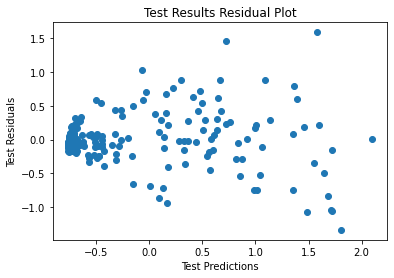

In [27]:
#now to show the results in a residual plot
test_residuals = test_target - test_predictions
plt.scatter(test_predictions,test_residuals)
plt.title("Test Results Residual Plot")
plt.xlabel("Test Predictions")
plt.ylabel("Test Residuals")
#plt.savefig('Figures/test_residuals.png')

In [28]:
#The residuals for the test data show no pattern, and has mostly even variance. It has a slight fanning, but certainly no more
#than the training data showed. Also, the range of values in the residuals are similar to the range of the values
#in the residuals of the training data. 

In [29]:
#I conclude that the model has performed just as well on the test data set as it did on the training data set. There doesn't
#appear to be any over fitting, and I am fairly confident that the model is not underfitting either. This model is 
#as robust as it can get given the data used to build it.